# Gaussian Process API Tutorial 3

Thank you for checking out our package!


By the end of this tutorial, you should be able to
- Use built in tools to model probabalistic samples
    by constructing 1d and 2d marginals 
    using adaptive binning

## Documentation
We'd like a generic way to fit the 1D and 2D marginal distribution
    for a higher dimensional set of samples.
We would like to do this in an efficient way that preserves characterstics
    of the distribution, avoiding binning effects.
The typical approach is to use a histogram.
However, assumptions about the number of desired bins for a histogram
    can introduce bias.
Many adaptive binning algorithms in the past use uneven bin widths
    for their adaptive binning.
At best, such an approach poses an optimization problem which 
    introduced a compuational burden that does not scale well,
    and at worst it is overfitting to a sample.

The method I use here is very simple.
I haven't seen it used before,
    but I would be shocked if I was the first person to come up with it.
We construct a histogram with n bins, scaled so the probability distribution
    is normalized within our limits.
We fit a gaussian process, using the histogram bins as training values.
This process is repeated for a histogram with n + 1 bins.
We then cross-evaluate the training sets to estimate the difference
    between the two gaussian process fits.
The maximum value of that difference is the Kolmogorov-Smirnov value
    for the two distributions.
We do this incrementing n until a desired KS value is achieved
    or until we encounter the maximum allowed number of bins
    (default 20).
For the set of fits with the minimum KS value,
    both sets of training points are included in the final 
    gaussian process fit.

One advantage to this method is that the final selected bin width
    has some physical significance as a scale length for the
    distribution.
Another advantage is that apart from the boundary,
    the histogram training points for n bins will be offset
    from that of n + 1 bins, giving us evenly spaced 
    points in the center of the distribution.
    
## grab_edge

These marginal fits have a grab edge option.

When initializing a marginal object, the samples which lie outside
    the given limits are discarded.
We are in effect, fitting the probability distribution only within
    a bounded region.
The grab_edge option is a set of boundary conditions for the probability
    distribution in such a bounded region.
This boundary condition assumption is that a distribution outside the
    given limits is effectively mirrored for one half a bin width.

The implementation involves adjusting the limits of the histogram
    such that half a bin hangs over the edge of our original limits,
    such that they are centered on the boundary.
Since we have pruned all of our samples outside of those original limits,
    the edge bins can only accept samples from a fraction of 
    the space covered by a non-edge bin.
Therefore, that fraction must be multiplied by the number of samples
    in the edge bin if we assume a uniform distribution in the
    space hanging over the edge of our limits.
These edge bins should only be used to fit the gaussian process,
    and not for anything else.


Let's import what we need for this tutorial!

In [1]:
import numpy as np
rs = np.random.RandomState(20220211)
from matplotlib import pyplot as plt

from gp_api.utils import sample_hypercube, Multigauss
from gp_api.marginals import Marginal

We want to generate plots!

In [2]:
%matplotlib inline

First, let's look at a 1-D example!

In [3]:
# Generate some reasonable limits
limits = np.zeros((1,2))
limits[:,1] = 1

# Initialize multigauss object
# This will randomly generate gaussians to draw samples from    # Generate some reasonable limits
n_gauss = 2
dim = 1
MG = Multigauss(n_gauss, dim, limits=limits,seed=rs)

# Pick a number of random samples to draw
n_sample = int(1e6)

# Generate random samples
x_sample = MG.rvs(n_sample)


Let's first pick a number of bins to fit data using.

We'll make two histograms, one with bins, and one with bins + 1.

We'll fit a gaussian process to each histogram.

We'll then cross-evaluate the training points to generate error bars, and fit another gaussian process using the combine data

The maximum of the cross-evaluations can be used as a goodness of fit statistic

In [4]:
# Define a function to train some data
def test_density_1d(sample_res=100,whitenoise=0.0,bins=8):

    # Initialize Marginal object
    # This object will allow us to construct a fit automatically
    # To the random samples
    marginal = Marginal(x_sample, limits)
    
    # Fit the 1d marginal using bins
    x_train_1, y_train_1 = marginal.fit_hist1d(bins,0)
    # Fit the 1d marginal using bins + 1
    x_train_2, y_train_2 = marginal.fit_hist1d(bins + 1,0)
    # Cross validate sample
    ks, gp_fit, x_train, y_train, y_error = \
        marginal.joint_training_goodness(x_train_1, y_train_1, x_train_2, y_train_2)
       
    # Find the sample space
    x_test = sample_hypercube(limits, sample_res)
    dx_test = (limits[0,1] - limits[0,0])/sample_res
    
    # Check the true pdf
    y_true = MG.true_pdf(x_test)
    y_true/= np.sum(y_true*dx_test)
    
    # Evaluate the test data
    y_test = gp_fit.mean(x_test)
    
    # Plot things
    plt.style.use('bmh')
    fig, ax = plt.subplots()
    
    # Plot the true pdf on top
    ax.plot(x_test[:,0],y_true,zorder=1,label='true_pdf',color='black')
    # Plot the histogram points for training set 1
    ax.scatter(x_train[:bins,0],y_train[:bins],zorder=2,s=8,edgecolor="black",label="training set 1")
    # Plot the histogram points for training set 2
    ax.scatter(x_train[bins:,0],y_train[bins:],zorder=2,s=8,edgecolor="black",label="training set 2")
    # Interpolation for combine training set
    ax.plot(x_test, y_test, zorder=0, label="combine evaluation")
    # Plot training error generated by cross-validating training sets
    ax.errorbar(x_train[:,0],y_train,yerr=y_error,fmt='none',color="gray",linewidth=1,zorder=0.)
    
    # Smooth things over
    ax.legend()
    
    return ks
    

0.02991419598865641


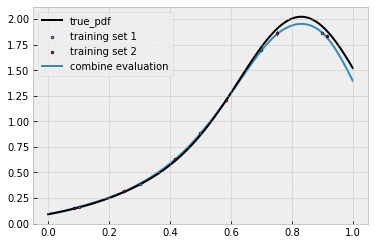

In [9]:
ks = test_density_1d(bins=5)

print(ks)

It looks like 5 bins is not enough to accurately fit a histogram.

This is not suprising.

The warning message is because some of the gaussian samples lie outside of our limits, and we disregard (prune) them.

Let's try 20 bins

0.004765034011336544


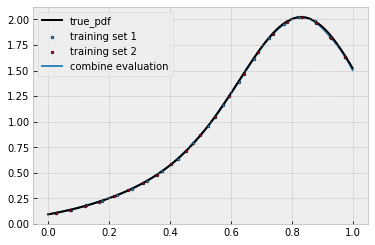

In [10]:
ks = test_density_1d(bins=20)

print(ks)

20 bins seems like enough bins to accurately contain the samples

Our convergence statistic has decreased considerably

But we can also pick the number of bins automatically to reduce the difference between the cross-evaluated samples.

Let's explore that next.

In [11]:
# Define a function to train some data
def test_marginal_1d(sample_res=100,whitenoise=0.0,max_bins=20):

    # Initialize Marginal object
    # This object will allow us to construct a fit automatically
    # To the random samples
    marginal = Marginal(x_sample, limits, max_bins=max_bins)
    
    # Fit the 1d marginal
    ks, bins, gp_fit, x_train, y_train, y_error = \
        marginal.fit_marginal1d(0,whitenoise=whitenoise)
    
    # Find the sample space
    x_test = sample_hypercube(limits, sample_res)
    dx_test = (limits[0,1] - limits[0,0])/sample_res
    
    # Check the true pdf
    y_true = MG.true_pdf(x_test)
    y_true/= np.sum(y_true*dx_test)
    
    # Evaluate the test data
    y_test = gp_fit.mean(x_test)
    
    # Plot things
    plt.style.use('bmh')
    fig, ax = plt.subplots()
    
    # Plot the true pdf on top
    ax.plot(x_test[:,0],y_true,zorder=1,label='true_pdf',color='black')
    # Plot the histogram points for training set 1
    ax.scatter(x_train[:bins,0],y_train[:bins],zorder=2,s=8,edgecolor="black",label="training set 1")
    # Plot the histogram points for training set 2
    ax.scatter(x_train[bins:,0],y_train[bins:],zorder=2,s=8,edgecolor="black",label="training set 2")
    # Interpolation for combine training set
    ax.plot(x_test, y_test, zorder=0, label="combine evaluation")
    # Plot training error generated by cross-validating training sets
    ax.errorbar(x_train[:,0],y_train,yerr=y_error,fmt='none',color="gray",linewidth=1,zorder=0.)
    
    # Smooth things over
    ax.legend()
    
    return bins, ks
    

Let's see what this function is doing

12 0.003858150393076798


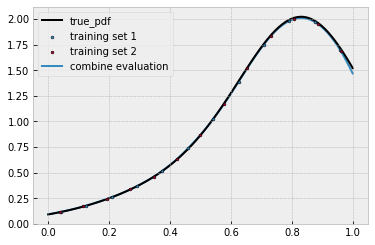

In [12]:
bins, ks = test_marginal_1d(max_bins=20)

print(bins, ks)

Our fitting algorithm has found that with 20 maximum allowed bins, the best fitting histograms with adjacent bins have 14 and 15 bins.

Any more bins, and we risk overfitting the sample.

Therefore, we have successfully trained our model!

## 2 Dimensional example

Now, let's do the same thing for a 2-Dimensional example, and try to reconstruct an image

In [13]:
# Generate some reasonable limits
dim = 2
limits = np.zeros((dim,2))
limits[:,1] = 1

# Initialize multigauss object
# This will randomly generate gaussians to draw samples from    # Generate some reasonable limits
n_gauss = 3
MG = Multigauss(n_gauss, dim, limits=limits,seed=rs)

# Pick a number of random samples to draw
n_sample = int(1e6)

# Generate random samples
x_sample = MG.rvs(n_sample)

In [14]:
# Define a function to train some data
def test_marginal_2d(sample_res=100,max_bins=20,cmap='plasma',grab_edge=False):

    # Initialize Marginal object
    # This object will allow us to construct a fit automatically
    # To the random samples
    marginal = Marginal(x_sample, limits,max_bins=max_bins)
    
    # Fit the 2d marginal
    ks, bins, gp_fit, x_train, y_train, y_error = \
        marginal.fit_marginal2d(0,1,grab_edge=grab_edge)
    
    # Find the sample space
    x_test = sample_hypercube(limits, sample_res)
    dx_test = (limits[:,1] - limits[:,0])/sample_res
    
    # Check the true pdf
    y_true = MG.true_pdf(x_test)
    y_true/= np.sum(y_true*np.prod(dx_test))
    
    # Evaluate the test data
    y_test = gp_fit.mean(x_test)
    
    # Plot things
    plt.style.use('bmh')
    fig, axes = plt.subplots(ncols=2)
    
    # generate a lambda for imshow
    y_display = lambda y: np.rot90(y.reshape((sample_res,sample_res)))
    
    # Generate a color
    ymin = min(min(y_true),min(y_test))
    ymax = min(max(y_true),max(y_test))
    
    # Plot the true pdf on top
    axes[0].imshow(
        y_display(y_true),
        extent=(0,1,0,1),
        vmin=ymin,
        vmax=ymax,
        cmap=cmap,
        zorder=1
    )
    axes[0].set_xlim(limits[0])
    axes[0].set_ylim(limits[1])
    
    # Plot the histogram for the training set
    axes[1].scatter(
        x_train[:,0], x_train[:,1],
        c=y_train,
        s=8,
        linewidth=0.3,
        edgecolor='black',
        vmin=ymin,
        vmax=ymax,
        cmap=cmap,
        zorder=2.,
        label="combine training set",
    )
    
    # Plot the evaluation
    axes[1].imshow(
        y_display(y_test),
        extent=(0,1,0,1),
        vmin=ymin,
        vmax=ymax,
        cmap=cmap,
        zorder=1
    )
    
    axes[1].set_xlim(limits[0])
    axes[1].set_ylim(limits[1])
        
    return bins, ks

In [ ]:
bins, ks = test_marginal_2d(max_bins=20,grab_edge=False)

print(bins, ks)

It's normal to prune a lot more samples in higher dimensions because more of them will lie out of bounds.

It's also normal to favor fewer bins for 2 dimensional samples, as the samples are really sorting into bins^2

# A higher dimensional example

In [16]:
# Generate some reasonable limits
dim = 3
limits = np.zeros((dim,2))
limits[:,1] = 1

# Initialize multigauss object
# This will randomly generate gaussians to draw samples from    # Generate some reasonable limits
n_gauss = 3
MG = Multigauss(n_gauss, dim, limits=limits,seed=rs)

# Pick a number of random samples to draw
n_sample = int(1e6)

# Generate random samples
x_sample = MG.rvs(n_sample)


In [17]:
def test_marginals_corner(
    dim=3,
    sample_res=100,
    n_sample=1000000,
    cmap='plasma',
    max_bins=20,
    grab_edge=False,
):
    # Initialize the marginal object
    marginal = Marginal(x_sample, limits, max_bins=max_bins)
    
    # Create a dictionary with all the marginals
    marg_dict = marginal.multifit_marginal1d2d(grab_edge=grab_edge)
    
    # Plot things
    fig, axes = plt.subplots(nrows=dim,ncols=dim,figsize=(2*dim,2*dim),sharex='col')

    # 1-d plots
    for i in range(dim):
        ax = axes[i,i]
        # Generate 1d test inputs
        x_test = sample_hypercube(limits[i,None],sample_res)
        dx = (limits[i,1]-limits[i,0])/sample_res
        
        # Evaluate test data
        y_test = marg_dict["1d_%d_gp_fit"%i].mean(x_test)
        # Generate bin number
        bins = marg_dict["1d_%d_bins"%i]
        
        # Histogram points for training set 1
        ax.scatter(
            marg_dict["1d_%d_x_train"%i][:bins,0],
            marg_dict["1d_%d_y_train"%i][:bins],
            zorder=2,
            s=8,
            edgecolor="black",
        )
        
        # Histogram points for training set 2
        ax.scatter(
            marg_dict["1d_%d_x_train"%i][bins:,0],
            marg_dict["1d_%d_y_train"%i][bins:],
            zorder=2,
            s=8,
            edgecolor="black",
        )
        # Plot interpolation for training set 3
        ax.plot(x_test, y_test, zorder=0)
        
        # Error bars for training set
        ax.errorbar(
            marg_dict["1d_%d_x_train"%i][:,0],
            marg_dict["1d_%d_y_train"%i],
            yerr=marg_dict["1d_%d_y_error"%i],
            fmt='none',
            color='gray',
            linewidth=1,
            zorder=0.,
        )
        
    # 2-D plots! 
    for i in range(dim):
        for j in range(i):
            # Remove unwanted plot
            axes[j,i].remove()
            # Pick out plot
            ax = axes[i,j]
            
            # Find sample space
            limits_2d = np.asarray([limits[i],limits[j]])
            x_test = sample_hypercube(limits_2d, sample_res)
            dx = (limits_2d[:,1] - limits_2d[:,0])/sample_res
            dA = np.prod(dx)
            
            # Generate lambda for y_display
            y_display = lambda y: np.rot90(y.reshape((sample_res,sample_res)).T)
            
            # Evaluate test data
            y_test = marg_dict["2d_%d_%d_gp_fit"%(i,j)].mean(x_test)
            
            # Generate color scale
            ymin = min(y_test)
            ymax = max(y_test)
            
            # Histogram points for training set
            ax.scatter(
                marg_dict["2d_%d_%d_x_train"%(i,j)][:,1],
                marg_dict["2d_%d_%d_x_train"%(i,j)][:,0],
                c=marg_dict["2d_%d_%d_y_train"%(i,j)],
                s=8,
                linewidth=0.3,
                edgecolor='black',
                vmin=ymin,
                vmax=ymax,
                cmap=cmap,
                zorder=2,                   
            )
            # Plot the test evaluations
            ax.imshow(
                y_display(y_test),
                extent=(0,1,0,1),
                vmin=ymin,
                vmax=ymax,
                cmap=cmap,
                zorder=1
            )
            ax.set_xlim(limits[i])
            ax.set_ylim(limits[j])
    return marg_dict
            

Let's run this corner plot example now!

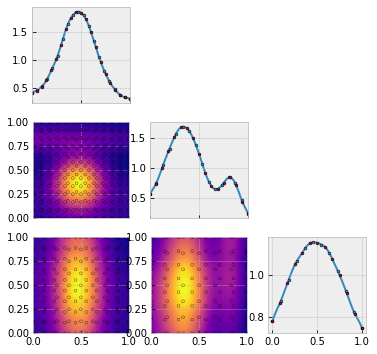

In [18]:
marg_dict = test_marginals_corner(max_bins=20,grab_edge=True)


The 1d and 2d marginals look satisfying!

Let's take a look at the keys from the dictionary produced by marg_dict.

It has the quantities we calculated before for each fit!

In [ ]:
print("bins!")
for key in marg_dict.keys():
    if "bins" in key:
        print(key, marg_dict[key])
        
print("ks values!")
for key in marg_dict.keys():
    if "ks" in key:
        print(key, marg_dict[key])
        
print("All the keys!")
for key in marg_dict.keys():
    print(key)